### Laboratorio 5

Stefano Aragoni, Carol Arevalo

In [3]:
#libterias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam


In [4]:
# Cargar el dataset MNIST
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalizar a [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

In [5]:
# Parámetros
img_shape = X_train[0].shape
latent_dim = 100

#### Generador
Estructura de su G(x) (Generador): El generador build_generator se define como una red neuronal feedforward que toma un vector de ruido como entrada y genera imágenes de 28x28 píxeles en escala de grises (como las del conjunto de datos MNIST). La estructura del generador incluye capas densas (fully connected) con activaciones LeakyReLU y normalización por lotes (BatchNormalization) para ayudar a estabilizar el proceso de entrenamiento. La última capa utiliza la función de activación 'tanh' para escalar la salida a un rango de [-1, 1], que es el rango de valores de los píxeles de las imágenes MNIST.

*Estrucutura*

Capa de entrada: Una capa densa (fully connected) con 128 neuronas y una función de activación LeakyReLU con alpha=0.2. La capa de entrada toma un vector de ruido como entrada, que es el espacio latente de la GAN.

Capa de Batch Normalization: Ayuda a estabilizar el proceso de entrenamiento proporcionando una normalización por lotes.

Capa densa con 256 neuronas y LeakyReLU: Proporciona una transformación lineal seguida de una función de activación no lineal.

Capa de Batch Normalization: Similar a la capa anterior, normaliza por lotes.

Capa densa con 512 neuronas y LeakyReLU: Proporciona una transformación lineal seguida de una función de activación no lineal.

Capa de Batch Normalization: Normaliza por lotes nuevamente.

Capa densa de salida con una función de activación tanh: La capa final genera una imagen de tamaño igual al de las imágenes MNIST (28x28x1) y utiliza la función de activación tanh para asegurarse de que las salidas estén en el rango [-1, 1].

Capa de Reshape: Esta capa reshapea la salida para que coincida con el tamaño de las imágenes MNIST (28x28x1).

In [6]:
# Generador
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

#### Discriminador
El discriminador build_discriminator es otra red feedforward que toma una imagen (real o generada) como entrada y produce una salida que representa la probabilidad de que la imagen sea real. La estructura del discriminador incluye capas densas con activaciones LeakyReLU y culmina en una capa densa con una sola neurona y función de activación sigmoide. Esta última capa produce una probabilidad entre 0 y 1, que indica si la imagen es real o generada por el generador.


*Estructura*
Capa de entrada: Una capa de aplanado (Flatten) que toma imágenes de tamaño 28x28x1 y las convierte en un vector unidimensional de 784 elementos.

Capa densa con 512 neuronas y LeakyReLU: Proporciona una transformación lineal seguida de una función de activación no lineal.

Capa densa con 256 neuronas y LeakyReLU: Otra capa densa que reduce la dimensionalidad de la representación.

Capa de salida con una sola neurona y función de activación sigmoide: La capa final produce una salida única que representa la probabilidad de que la imagen de entrada sea real (1) o falsa (0).


In [7]:
# Discriminador
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [8]:
# Compilar Discriminador
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Generador
generator = build_generator()
z = Input(shape=(latent_dim,))
img = generator(z)

# El discriminador no debe ser entrenado durante el entrenamiento del generador
discriminator.trainable = False

# Discriminador para evaluar el generador
validity = discriminator(img)

# El modelo combinado
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

##### Resultados antes y después del proceso de entrenamiento

El código realiza un ciclo de entrenamiento que dura 10000 épocas. Durante este proceso, el generador intenta mejorar su capacidad para generar imágenes realistas, mientras que el discriminador intenta mejorar su capacidad para distinguir entre imágenes reales y generadas. Al final del entrenamiento, se generan 25 imágenes utilizando ruido aleatorio como entrada para el generador, y se muestran en un gráfico utilizando matplotlib. Estas imágenes representan el resultado después del entrenamiento y deberían mostrar dígitos escritos a mano que se asemejan a los del conjunto de datos MNIST.

In [9]:
# Entrenamiento
epochs = 10000
batch_size = 128
half_batch = batch_size // 2

for epoch in range(epochs):
    # Entrenar el discriminador
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    gen_imgs = generator.predict(noise)
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))
    d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch(noise, valid_labels)

    # Imprimir el progreso
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")


2/2 [==============================] - 0s 6ms/step
0/10000 [D loss: 0.5050483196973801 | D accuracy: 57.8125] [G loss: 0.4974654018878937]
2/2 [==============================] - 0s 3ms/step
1/10000 [D loss: 0.34178799763321877 | D accuracy: 85.9375] [G loss: 0.5138484239578247]
2/2 [==============================] - 0s 4ms/step
2/10000 [D loss: 0.27378844236955047 | D accuracy: 100.0] [G loss: 0.5563510060310364]
2/2 [==============================] - 0s 4ms/step
3/10000 [D loss: 0.22121060267090797 | D accuracy: 100.0] [G loss: 0.5724542140960693]
2/2 [==============================] - 0s 3ms/step
4/10000 [D loss: 0.18788823229260743 | D accuracy: 100.0] [G loss: 0.6086475849151611]
2/2 [==============================] - 0s 3ms/step
5/10000 [D loss: 0.16335649508982897 | D accuracy: 100.0] [G loss: 0.6085183024406433]
2/2 [==============================] - 0s 4ms/step
6/10000 [D loss: 0.13996573816984892 | D accuracy: 100.0] [G loss: 0.6709957718849182]
2/2 [==========================

1/1 [==============================] - 0s 277ms/step


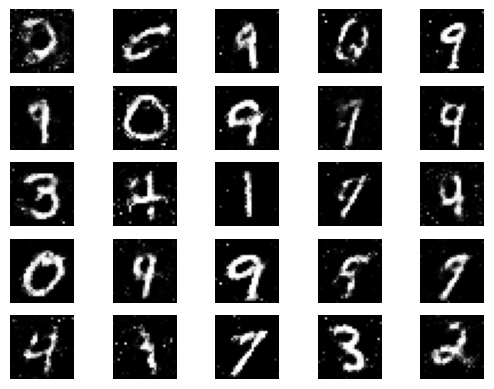

In [10]:
# Generar imágenes para mostrar
noise = np.random.normal(0, 1, (25, latent_dim))
gen_imgs = generator.predict(noise)

# Escalar imágenes a [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(gen_imgs[i * 5 + j, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
plt.show()


Es importante destacar que las pérdidas y la precisión del discriminador pueden fluctuar ampliamente durante el entrenamiento, ya que el generador y el discriminador están en constante competencia. El generador trata de engañar al discriminador, por lo que es normal ver que la precisión del discriminador no siempre sea alta.

Los resultados finales, que muestran el D loss y G loss al final del entrenamiento, indican que el generador está generando imágenes que son más difíciles de distinguir por parte del discriminador. Un D loss más alto y un G loss más bajo al final del entrenamiento son indicativos de un generador más efectivo.

#### Análisis de resutlados


